# Earthquake seismology with DAS

#### Todo List:
1. Reference earthquakes by Evid rather than dataframe index
2. Make a map of all of the detected events
3. Try some xcorr

In [2]:
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import datetime
import pandas as pd
from dasquakes import sintela_to_datetime, open_sintela_file, local_earthquake_quicklook, data_wrangler, haversine
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from libcomcat.search import search
from libcomcat.dataframes import get_summary_data_frame
import geopy.distance

ERROR 1: PROJ: proj_create_from_database: Open of /home/velgueta/.conda/envs/python-obspy/share/proj failed


### Get a list of events from USGS

In [7]:
events = search(starttime = datetime.datetime(2022, 3, 17, 0, 0), 
                endtime   = datetime.datetime(2023,1,9,0,0),
                minmagnitude=1.4,
                maxmagnitude=1.69,
                maxradiuskm=100, 
                latitude=47.60, 
                longitude=-122.33)

print("Returned %s events" % len(events))
 

Returned 84 events


### Choose an event to analyze

In [ ]:
event_df = get_summary_data_frame(events)
event_df = event_df.sort_values(by=['time'],ascending=False)
event_df


#event_df.iloc[0::]

In [ ]:
dist_kmarray = []
magnituddarray = []
thisid = []

In [ ]:
for index,this_event in event_df.iterrows():
    
    this_id = this_event['id']
    
    this_event_new = event_df[event_df.id==this_id]
    
    latitude_loc = this_event_new['latitude']
    longitude_loc = this_event_new['longitude']
    latitude_ref = 47.60
    longitude_ref = -122.33
    
    coords_1 = (this_event_new.latitude.to_numpy()[0], this_event_new.longitude.to_numpy()[0])
    coords_2 = (47.6531, -122.3079)
    dist_km = geopy.distance.geodesic(coords_1, coords_2).km
    
    #distance = haversine(longitude_loc,latitude_loc,longitude_ref,latitude_ref)
    #print(distance)
    
    #if  dist_km  <600:#if when I want to avoid the previus datas
    #    continue
    magnituddarray.append(this_event_new['magnitude'].to_numpy()[0])
    #distance = haversine(longitude_loc,latitude_loc,longitude_ref,latitude_ref)
    thisid.append(this_id)
    dist_kmarray.append(dist_km)
    #if distance < 500:
    #    continue
    
    print(this_event['id'])
    
    cable = 'whidbey'
    record_length = 5 #minutes
    t0 = this_event_new['time'].iloc[0]
    
    prefix, network_name, datastore = data_wrangler(cable,record_length,t0)
        
    try:
        data,dates,attrs = open_sintela_file(prefix,
                                             t0,
                                             datastore,
                                             number_of_files=record_length,
                                             verbose=True)
        
        #stitle=f"M {this_event_new['magnitude'].to_numpy()[0]}, "\
        #   f"{this_event_new['location'].to_numpy()[0]}, "\
        #   f"{str(this_event_new['time'].to_numpy()[0])[0:-10]} UTC"
      
        #test folder ;
        #filename = f"testsavingdataraw_event/"+this_id

        #filename = f"/data/fast0/veronica-scratch/"+'us6000iv6c'
        filename = f"/data/fast0/veronica-scratch/"+this_id
        timestamps = []
   
        #25200s = 7 hours
        #28800s = 8hours
        for d in dates:
            if type(d) == datetime.datetime:
                timestamps.append(int((d.timestamp()-25700)*10**6))
            #timestamps.append(int((d.timestamp())*10**6))
            else:
                timestamps.append(d)

        g=h5py.File(filename+'.h5','w')
        #no descomentar esto nunca, es solo un ejemplo de como ponerle nombre al archivo .h5g=h5py.File('this_id.h5','w')
        g.create_dataset('Acquisition/Raw[0]/RawData',data=data)
        g.create_dataset('Acquisition/Raw[0]/RawDataTime',data=np.array(timestamps))
        g['Acquisition'].attrs.update(attrs)   
        g.close()
    except ValueError:
        continue
   

test, to see saved files

In [5]:
chan_min=0
chan_max=-1

this_data1 = np.array([])
this_time1 = np.array([])


data_file = h5py.File('testsavingdataraw_event/uw61876522.h5','r')

this_data = np.array(data_file['Acquisition/Raw[0]/RawData'][:,chan_min:chan_max])
this_time = np.array(data_file['Acquisition/Raw[0]/RawDataTime'])
            
    
this_time1 = sintela_to_datetime(this_time)
#this_time2 = sintela_to_datetime(stamp)

this_data1 = this_data
attrs1=dict(data_file['Acquisition'].attrs)

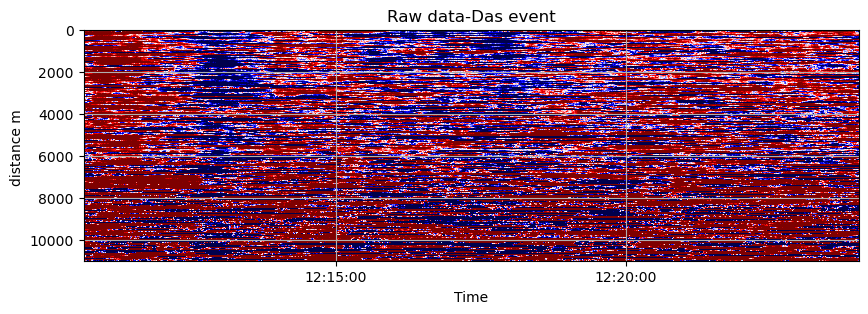

In [6]:
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import matplotlib.dates as mdates

#date_format = mdates.DateFormatter('%H:%M:%S')

date_format = mdates.DateFormatter('%H:%M:%S')
x_lims1 = mdates.date2num(this_time1)
x_max = this_data1.shape[1] * attrs1['SpatialSamplingInterval']
fig,ax=plt.subplots(figsize=(10,3))
plt.imshow(this_data1.T,cmap='seismic',aspect='auto',vmin=-0.2,vmax=0.2,extent=[x_lims1[0],x_lims1[-1],x_max,0])
plt.title('Raw data-Das event')
plt.xlabel("Time")
plt.ylabel("distance m ")

ax.xaxis.set_major_formatter(date_format)
ax.xaxis_date()
plt.grid()
plt.show()